## PreProcess Images and feed into CNN

In [1]:
# Mount Google Drice
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip install pyrsgis

In [3]:
!git clone https://github.com/maxjonasbehrens/master_thesis_code
#%cd /content/master_thesis_code
#!git pull

Cloning into 'master_thesis_code'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 175 (delta 89), reused 119 (delta 48), pack-reused 0
Receiving objects: 100% (175/175), 240.03 KiB | 664.00 KiB/s, done.
Resolving deltas: 100% (89/89), done.


In [0]:
%load /content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import scipy.io

Warning! matplotlib_scalebar library not found.


In [0]:
# Import own module to preprocess images
import imp
sat_images = imp.new_module('sat_images')
exec(open("/content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py").read(), sat_images.__dict__)

## Test for one image

In [0]:
# Download test image from drive
al01_2016_path = "/gdrive/My Drive/nuts_geotiff/DE22_2012.tif"

ds1, featuresAL01 = pyrsgis.raster.read(al01_2016_path)

In [8]:
# Print its shape
print("AL01 shape: ",featuresAL01.shape)

AL01 shape:  (3, 3588, 8325)


In [0]:
# Resize original image to compatible size
orig_img = np.swapaxes(featuresAL01,0,-1)
orig_resized = resize(orig_img, (256,256))

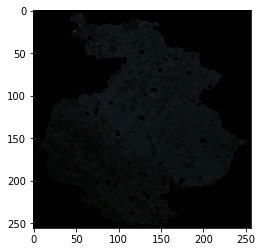

In [13]:
# Show the original image
plt.imshow(orig_resized, interpolation='nearest')
plt.show()

In [14]:
# Check the data frame
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/nuts_gdp_cleaned.csv")
y_dat.head()

,region,year,value,code,country
0,BE,2008,33100.0,BE,Belgium
1,BE1,2008,61100.0,BE,Belgium
2,BE10,2008,61100.0,BE,Belgium
3,BE2,2008,33100.0,BE,Belgium
4,BE21,2008,39200.0,BE,Belgium


In [0]:
# List of all files in directory
mypath = "/gdrive/My Drive/nuts_geotiff/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [0]:
# PreProcess images with certain resolution
res = 512
x,y,label = sat_images.create_data(onlyfiles,mypath,y_dat,resolution=res,night=False)
# Save ndarray to reproduce
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_day_orig_512.mat", mdict={'x': x}, oned_as='row')

Image processed:  0  of  910
Image processed:  10  of  910
Image processed:  20  of  910


In [0]:
# Load input from scratch
x = scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_all_input_512.mat")['x']
y, label = sat_images.create_y_label(onlyfiles,mypath,y_dat)

In [0]:
# Print shape of images
print('Shape of x: ',len(x))
print('Shape of y: ',len(y))
print('Shape of labels: ', len(label))

Shape of x:  558
Shape of y:  558
Shape of labels:  558


In [0]:
# Make x to a 3 channel image when using night images
x = np.repeat(x[..., np.newaxis], 3, -1)
print(x.shape)

(558, 512, 512, 3)


## Create Train and Test Sets

In [0]:
# Create list of unique regions
regions = []
for i in range(len(label)):
  regions.append(label[i].rsplit('_',1)[0])

regions = np.unique(regions)
print(len(regions))

93


In [0]:
# Split regions into train and test set
msk = np.random.rand(len(regions)) < 0.7
train_split = regions[msk]
test_split = regions[~msk]
print(len(train_split))
print(len(test_split))

67
26


In [0]:
# Split whole data set into test and train based on split regions
import math
label_train = []
label_test = []
x_train = []
y_train = []
x_test = []
y_test = []

# Split into train and test based on previous region split
for i in range(len(label)):
  if label[i].rsplit('_',1)[0] in train_split:
    if math.isnan(y[i]):
      pass
    else:
      label_train.append(label[i])
      x_train.append(x[i])
      y_train.append(int(y[i]))
  else:
    if math.isnan(y[i]):
      pass
    else:
      label_test.append(label[i])
      x_test.append(x[i])
      y_test.append(int(y[i]))

# Transform into numpy array
label_train = np.array(label_train)
label_test = np.array(label_test)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)  

# Print Shape
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(286, 512, 512, 3)
(148, 512, 512, 3)
(148,)


In [0]:
# Only execute when using night images, since they are 1d
x_train = np.array([x_train])
x_train = np.moveaxis(x_train,0,-1)
print(x_train.shape)
x_test = np.array([x_test])
x_test = np.moveaxis(x_test,0,-1)
print(x_test.shape)

(286, 512, 512, 3, 1)
(148, 512, 512, 3, 1)


In [0]:
# Deep Model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=(512,512,1), activation='relu'))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, activation = 'linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Transfer Learning
base_model = tf.keras.applications.MobileNet(input_shape=(512,512,3),include_top=False)
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
preds=tf.keras.layers.Dense(units=1, activation = 'linear')(x)
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

17227776/17225924 [==============================] - 1s 0us/step


In [0]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [0]:
# Data Augmentation
training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
# Data Preparation
batch_size = 5

# Define the data flow
training_generator = training_data_generator.flow(x_train,y_train,batch_size=batch_size)
test_generator = test_data_generator.flow(x_test,y_test,batch_size=1,shuffle=False)

In [0]:
# Calculate the number of steps
training_steps = training_generator.n/batch_size

# Run the model
model.fit_generator(training_generator,
                    steps_per_epoch=training_steps,
                    epochs = 100,
                    verbose = 1
                   )

Epoch 1/100
58/57 [==============================] - 25s 438ms/step - loss: 347219103.0766 - mean_squared_error: 344693568.0000 - mean_absolute_error: 12921.1885
Epoch 2/100
58/57 [==============================] - 18s 308ms/step - loss: 166973392.8075 - mean_squared_error: 168419072.0000 - mean_absolute_error: 9376.7510
Epoch 3/100
58/57 [==============================] - 18s 308ms/step - loss: 158110951.4784 - mean_squared_error: 158260992.0000 - mean_absolute_error: 9118.2188
Epoch 4/100
58/57 [==============================] - 18s 306ms/step - loss: 147959354.9010 - mean_squared_error: 146895344.0000 - mean_absolute_error: 8613.9072
Epoch 5/100
58/57 [==============================] - 18s 310ms/step - loss: 126158127.5803 - mean_squared_error: 124743136.0000 - mean_absolute_error: 7875.1206
Epoch 6/100
58/57 [==============================] - 18s 306ms/step - loss: 94128973.3866 - mean_squared_error: 94482928.0000 - mean_absolute_error: 7231.8521
Epoch 7/100
58/57 [================

In [0]:
# Calculate the test performance
test_score = model.evaluate_generator(test_generator)
print('Test loss: '+str(test_score[0]))
print('Test MSE: '+str(test_score[1]))
print('Test MAE: '+str(test_score[2]))

Test loss: 213706958.70185646
Test MSE: 213706930.0
Test MAE: 10974.577
